In [56]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree as KDTree
from sklearn.preprocessing import RobustScaler

# Read in tTEM Data

In [57]:
import io
def read_work_bench_xyz_mod(fname):
    with open(fname, 'r') as fid:
        lines = fid.readlines()
    n_header_max = 100
    for ii, line in enumerate(lines):
        if '/' in line:
            pass
        else:
            break

    header = lines[ii-1].split()[1:]
    n_columns = len(header)
    n_sounding = len(lines[ii:])
    data = np.zeros((n_sounding, n_columns))
    for jj, line in enumerate(lines[ii:]):
        data[jj,:] = np.array(line.split(), dtype=float)
    df = pd.DataFrame(data=data, columns=header)
    tmp_thk = np.array(header)[['THK' in header for header in header]]
    thk_names = tmp_thk[:int(len(tmp_thk)/2)]
    tmp_rho = np.array(header)[['RHO' in header for header in header]]
    rho_names = tmp_rho[:int(len(tmp_thk)/2)+1]
    topo = df[['UTMX', 'UTMY', 'ELEVATION']].values[:, :]
    hz = np.unique(df[thk_names].values)
    hz = np.r_[hz, hz[-1]]
    resistivity= df[rho_names].values[:,:]
    line = df['LINE_NO'].values
    return df, topo, hz, resistivity, line

In [112]:
file_name = "Data/Inversion_FIles/LCI_I02_MOD_inv.xyz"
df_tTEM, topo_tTEM1, hz_tTEM, resistivity_tTEM, line_tTEM = read_work_bench_xyz_mod(file_name)
hz_ft= hz_tTEM * 3.28084
depth_tTEM = np.cumsum(hz_tTEM)


# Read in AEM Data

In [113]:
df_AEM = pd.read_csv("Data/AEM_data/AEM_data.csv")
topo_AEM1, hz_AEM= np.genfromtxt("Data/AEM_data/topo.csv", delimiter = ','),np.genfromtxt("Data/AEM_data/hz.csv", delimiter = ',')
resistivity_AEM = np.genfromtxt("Data/AEM_data/resistivity.csv", delimiter = ',')
depth_AEM = np.cumsum(hz_AEM)

# Co-locate AEM and tTEM data

In [114]:
pts_AEM = np.append(topo_AEM1[:,0], topo_AEM1[:,1]).reshape([2, topo_AEM1.shape[0]]).T
pts_tTEM = np.append(df_tTEM.UTMX.values, df_tTEM.UTMY.values).reshape([2, len(df_tTEM)]).T

tree = KDTree(pts_tTEM)
dist, ind = tree.query(pts_AEM)

max_dist = 30
ind_AEM = np.arange(len(pts_AEM))[dist<max_dist]
ind_tTEM = ind[dist<max_dist]


scaler = RobustScaler()
topo_AEM = topo_AEM1[ind_AEM]
res_AEM = resistivity_AEM[ind_AEM]
res_AEM_norm = scaler.fit_transform(np.log10(res_AEM).reshape(-1,1)).reshape(res_AEM.shape)
topo_tTEM = topo_tTEM1[ind_tTEM]
res_tTEM = resistivity_tTEM[ind_tTEM]
DOI_tTEM = df_tTEM.DOI_STANDARD.values[ind_tTEM]* 3.28084
res_tTEM_norm = scaler.fit_transform(np.log10(res_tTEM).reshape(-1,1)).reshape(res_tTEM.shape)

Text(0.5, 1.0, 'Colocated Points')

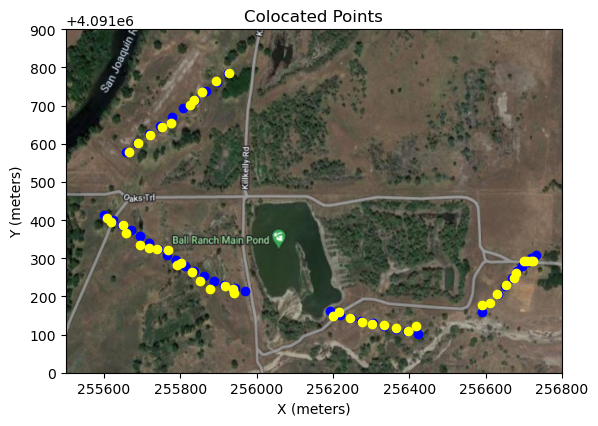

In [127]:
img = plt.imread('Data/tTEM_br.png')
extent = [255340.296875, 256848.921875, 4090839.0, 4091982.25]
plt.imshow(img, extent = extent)
plt.scatter(topo_AEM[:,0], topo_AEM[:,1], color = 'blue')
plt.scatter(topo_tTEM[:,0], topo_tTEM[:,1], color = 'yellow')
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.xlim(255500, 256800)
plt.ylim(4091000, 4091900)
plt.title("Colocated Points")

# Get Data Above a Max Depth

In [116]:
max_depth = 30
ind_above = np.where(depth_tTEM<max_depth)[0]
res_above_tTEM = res_tTEM_norm[:,ind_above]
res_above_avg_tTEM = np.dot(res_above_tTEM, hz_tTEM[ind_above])/hz_tTEM[ind_above[-1]]

ind_above = np.where(depth_AEM<max_depth)[0]
res_above_AEM = res_AEM_norm[:,ind_above]
res_above_avg_AEM = np.dot(res_above_AEM, hz_AEM[ind_above])/hz_AEM[ind_above[-1]]

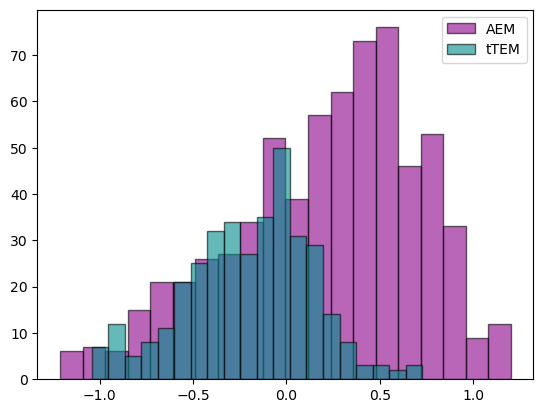

In [117]:
plt.hist(res_above_tTEM.flatten(), label = "AEM", bins = 20, color = 'darkmagenta', alpha = 0.6, edgecolor='black')
plt.hist(res_above_AEM.flatten(), label = "tTEM", alpha = 0.6, bins = 20, color = 'darkcyan', edgecolor='black')
plt.legend()

# Compare AEM and tTEM profiles

In [166]:
def get_line_data(dx, resistivity, topo, hz, DOI, stepsize):
    X, Y = topo[:,0], topo[:,1]
    n = resistivity.shape[1]
    hz = np.cumsum(hz)
    print(n)
    indexes, distance, res, elev=np.zeros([len(X)]),np.zeros([n, len(X)]),np.zeros([n, len(X)]),np.zeros([n, len(X)])
    for i in range(len(X)):
        if i == 0:
            distance[:,i]=0
        else:
            distance[:,i]= np.ones(n)*(np.sqrt((X[i]-X[i-1])**2+(Y[i]-Y[i-1])**2)+distance[0,i-1])
        res[:,i] = resistivity[i]
        #elev[:,i] = topo[:,2][int(indexes[i])]-hz
        elev[:,i] = hz
    distance_plot = np.arange(int(distance.max())+1, step = stepsize)
    res_plot, elev_plot = np.ones([n, len(distance_plot)])*np.nan, np.ones([n, len(distance_plot)])
    index, next_index  = 0, False
    for i in range(len(distance_plot)):
        if index>len(X)-1:
                break
        if abs(distance_plot[i]-distance[0, index])<dx:
            res_plot[:,i] = res[:,index]
            next_index = True
        elif next_index:
            if distance[0, index]-distance[0,index+1]==0:
                index = index + 1
            index = index+1
            next_index = False
        elev_plot[:,i] = hz
    return res_plot, distance_plot, elev_plot, X, Y, DOI, distance[0]

def plot_ttem(res_tTEM, topo_tTEM, hz_ft, min_X, max_X, min_Y, max_Y):
    x , y= topo_tTEM[:,0], topo_tTEM[:,1]
    boolean1 = np.where(np.logical_and(x>min_X, x<max_X))[0]
    boolean2 = np.where(np.logical_and(y>min_Y, y<max_Y))[0]
    boolean = np.intersect1d(boolean1, boolean2)
    res, dist, elev, X, Y, DOI, dists = get_line_data(
        10, res_tTEM[boolean], topo_tTEM[boolean], hz_ft,DOI_tTEM[boolean], 1)
    
    plt.title("tTEM Resistivity Profile")
    plt.pcolormesh(dist, elev, res, vmin = -1.5, vmax = 0.7)
    plt.axhline(y = 17, color = 'black', linestyle = '--', label = 'water table')
    plt.plot(dists, DOI, label = "DOI")
    plt.legend()
    plt.ylim(0, 40)
    plt.gca().invert_yaxis()
    cbar = plt.colorbar()
    cbar.set_label("Normalized Resistivity(ohm-meters)")
    plt.ylabel("Depth (Feet)")
    plt.xlabel("Distance (meters)")

def plot_aem(res, topo, hz_ft, min_X, max_X, min_Y, max_Y):
    x, y = topo[:,0], topo[:,1]
    boolean1 = np.where(np.logical_and(x>min_X, x<max_X))[0]
    boolean2 = np.where(np.logical_and(y>min_Y, y<max_Y))[0]
    boolean = np.intersect1d(boolean1, boolean2)
    res, dist, elev, X, Y, DOI, dists = get_line_data(
        10, res[boolean], topo[boolean], hz_ft,5, 1)
    
    plt.title("AEM Resistivity Profile")
    plt.pcolormesh(dist, elev, res, vmin=-1.5, vmax = 0.7)
    plt.ylim(0, 40)
    plt.gca().invert_yaxis()
    cbar = plt.colorbar()
    cbar.set_label("Normalized Resistivity(ohm-meters)")
    plt.ylabel("Depth (Feet)")
    plt.xlabel("Distance (meters)")
    plt.axhline(y = 17, color = 'black', linestyle = '--', label = 'water table')
    

25
30


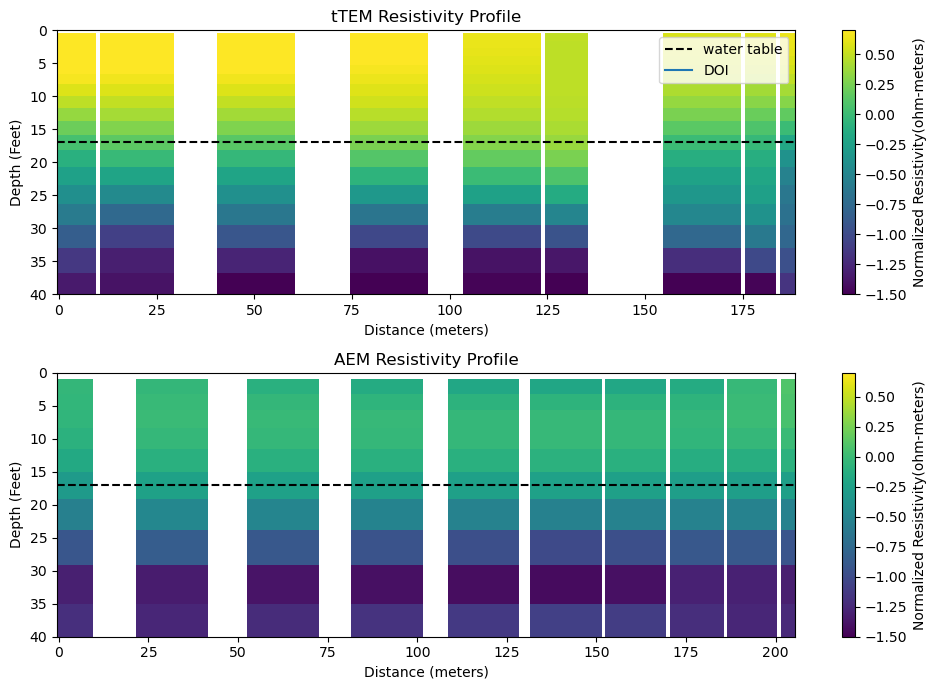

In [167]:
plt.figure(figsize=(10, 7))
plt.subplot(211)
plot_ttem(res_tTEM_norm, topo_tTEM, hz_tTEM,256500, 257000, 4090839.0, 4091982.25)

plt.subplot(212)
plot_aem(res_AEM_norm, topo_AEM, hz_AEM,256500, 257000, 4090839.0, 4091982.25)

plt.tight_layout()

25
30


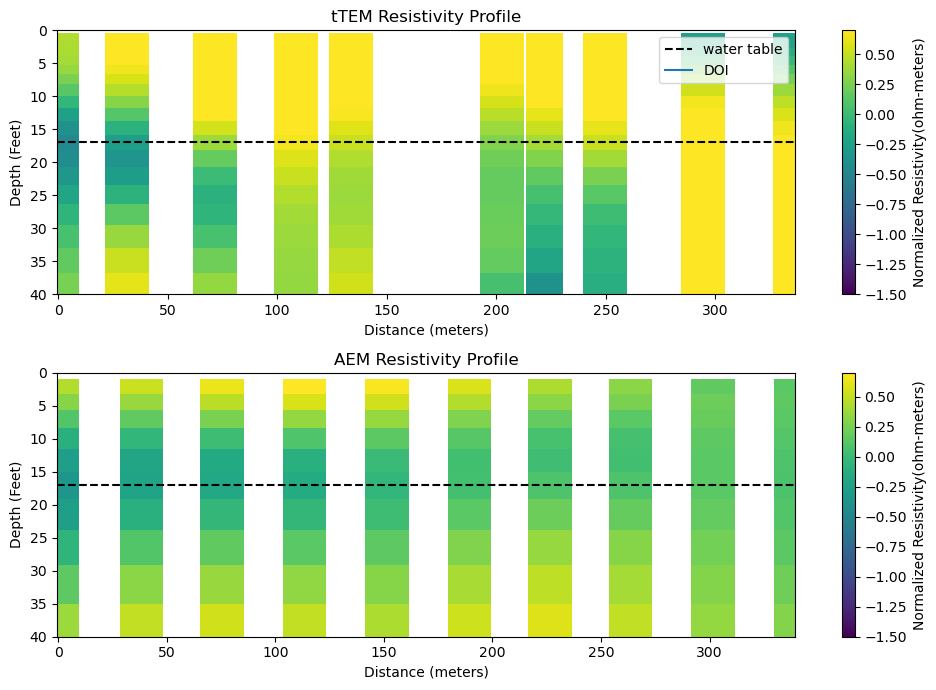

In [168]:

plt.figure(figsize=(10, 7))
plt.subplot(211)
plot_ttem(res_tTEM_norm, topo_tTEM, hz_tTEM,0, 256500,4091500, 4092000)

plt.subplot(212)
plot_aem(res_AEM_norm, topo_AEM, hz_AEM,0, 256500,4091500, 4092000)

plt.tight_layout()

25
30


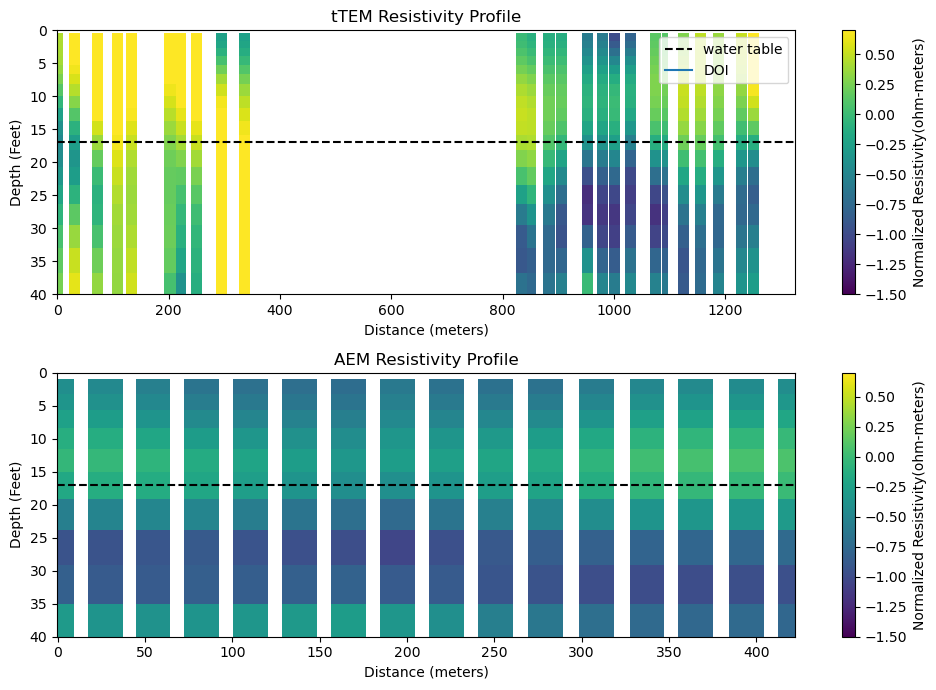

In [175]:

plt.figure(figsize=(10, 7))
plt.subplot(211)
plot_ttem(res_tTEM_norm, topo_tTEM, hz_tTEM,0, 256000,4090000, 40915000)

plt.subplot(212)
plot_aem(res_AEM_norm, topo_AEM, hz_AEM,0, 256000,4090000, 4091500)

plt.tight_layout()

In [121]:

#get AEM sounding above 300 ft
max_depth = 40
ind_above = np.where(depth_AEM<max_depth)[0]
res_above_AEM = res_AEM_norm[:,ind_above]
N = res_above_AEM.shape[1]
tTEM_AEM = np.zeros(res_above_AEM.shape)
for i in range(N):
    depth_temp=depth_AEM[i]
    if i == 0:
        ind_above = np.where(depth_tTEM<depth_temp)[0]
        tTEM_AEM[:,i]= np.mean(res_tTEM_norm[:,ind_above], axis = 1)
    else:
        ind_above = np.where(np.logical_and(depth_tTEM<depth_AEM[i+1], depth_tTEM>depth_AEM[i-1]))[0]
        tTEM_AEM[:,i] = np.mean(res_tTEM_norm[:,ind_above], axis =1)
        
    print(ind_above)

[0]
[1 2 3 4]
[3 4 5 6]
[5 6 7 8]
[ 7  8  9 10]
[ 9 10 11]
[11 12 13]
[12 13 14 15]
[14 15 16]
[16 17 18]


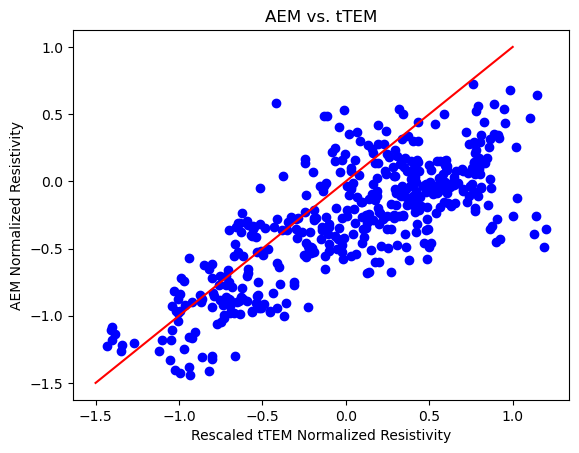

In [122]:
plt.scatter(tTEM_AEM.flatten(), res_above_AEM.flatten(), color = 'blue')
plt.xlabel("Rescaled tTEM Normalized Resistivity")
plt.ylabel("AEM Normalized Resistivity")
plt.title("AEM vs. tTEM")
plt.plot([-1.5, 1], [-1.5, 1], c = 'red')